#Neural Network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, show, clf

In [2]:
np.random.seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/AprendizadoMaquina/classification2.txt', header=None)

Mounted at /content/drive


In [4]:
print("Head of the dataframe:")
display(df.head())
print("Shape of the dataframe:", df.shape)

Head of the dataframe:


,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


Shape of the dataframe: (118, 3)


# Network construction
In this part, we create functions to initialize layers and build the architecture.

- `make_new_layer(dout, din, sigma=0.2, bias=False)`: creates a uniform weight matrix.

- `make_network(dims)`): creates the list of layers with weights and biases.

Note: The bias parameter in make_new_layer is not used to create a separate bias; biases are explicitly created in make_network.


In [5]:
def make_new_layer(dout, din, sigma=0.2, bias=False):
    if bias:
        din += 1
    return np.random.uniform(-sigma, sigma, (dout, din))


def make_network(dims):
    net = []
    for i in range(len(dims) - 1):
        # w: (dims[i+1], dims[i])
        # b: (dims[i+1], 1)
        net.append({
            'w': make_new_layer(dims[i+1], dims[i]),
            'b': make_new_layer(dims[i+1], 1)
        })
    return net

# Example
net = make_network([2, 50, 1])
print("Rede criada com", len(net), "camadas (excluíndo input).")
print("Shape w primeira camada:", net[0]['w'].shape, "shape b:", net[0]['b'].shape)

Rede criada com 2 camadas (excluíndo input).
Shape w primeira camada: (50, 2) shape b: (50, 1)


# Input and label extraction and normalization

- Extracts the first two columns as features (X) and the last column as the label (y).
- Applies normalization (z-score) per column: (X − mean) / standard deviation.

**Note:** In the original code, there are two normalization steps (one before and one after); only one is necessary — here I show the normalization that will be used during training.


In [6]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

m = np.mean(X, axis=0)
s = np.std(X, axis=0)
X = (X - m) / s  # normalization

print("Shape X:", X.shape, "Shape y:", y.shape)
print("Mean (before):", m)
print("Standard deviation (before):", s)


Shape X: (118, 2) Shape y: (118,)
Mean (before): [0.05477891 0.18310156]
Standard deviation (before): [0.49454485 0.51753592]


# Activation functions

- We implement Sigmoid, ReLU, and the required derivatives.
- The sigmoid uses `np.clip` to avoid numerical overflow in `exp`.
- Choose the activation function by setting the `activation` and `derivative` variables.


In [7]:
# ACTIVATIONS AND DERIVATIVES
def sigmoid(z):
    # np.clip prevents numerical overflow in exp
    return 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))

def deriv_sigmoid(a):
    # receives a = sigmoid(z)
    return a * (1 - a)

def relu(z):
    return np.maximum(z, 0.0)

def deriv_relu(a):
    # returns 1 where a > 0, 0 otherwise
    return np.where(a > 0, 1.0, 0.0)

def tanh(z):
    # computes tanh(z)
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def deriv_tanh(a):
    # receives a = tanh(z)
    return 1 - a**2

# Configure activation for the hidden layers
activation = relu
derivative = deriv_relu


# Forward propagation

- Computes the network output layer by layer.
- Stores the lists of activations (`a_list`) and pre-activations (`z_list`) for use in backpropagation.
- Returns: scalar output, list of activations, and list of `z` values (pre-activations).


In [8]:
# FORWARD PROPAGATION
def forward_prop(x, net, get_z=False):
    """
    x: vector of shape (n_features,) or (n_features, 1)
    net: list of layers
    get_z: if True, returns the pre-activation (z) of the last layer
           (useful for debugging)

    Returns:
      - if get_z=False: (y_pred_scalar, a_list, z_list)
      - if get_z=True: z_last[0][0] (scalar value of the final pre-activation)
    """
    # Ensure x has column-vector shape
    if len(x.shape) == 1:
        x = x.reshape(x.shape[0], 1)  # (n_features, 1)

    a_list = [x]  # a_0 = input
    z_list = [x]  # z_0 is not really z, but initialized this way for compatibility

    L = len(net)
    for i, layer in enumerate(net):
        w, b = layer['w'], layer['b']
        x = np.dot(w, x) + b  # z = W*x + b
        z_list.append(np.array(x))  # store pre-activation

        if i < L - 1:
            # hidden layers -> apply chosen activation function
            x = activation(x)
        else:
            # last layer -> apply sigmoid to obtain probability
            z = x
            x = sigmoid(x)

        a_list.append(x)  # activations per layer

    if get_z:
        # return scalar pre-activation of the last layer
        return z[0][0]

    # return: scalar output (y_pred), list of activations, list of z values
    return x[0][0], a_list, z_list


# Backpropagation (gradients)

- Implements classic backpropagation (for the entire batch): accumulates gradients per example and computes their average.
- Uses the `derivative` function defined earlier.
- **Note:** This backpropagation iterates over each example (for-loop) — it is not vectorized and may be slow for large datasets.


In [9]:

def backprop(net, X, Y):
    L = len(net) + 1
    m = X.shape[0]
    grad = []
    for layer in net:
        grad.append({
            'w': np.zeros(layer['w'].shape),
            'b': np.zeros(layer['b'].shape)
        })
    for k in range(m):
        x = X[k, :]
        y = Y[k]
        _, a, _ = forward_prop(x, net)
        d = a[L-1] - y
        deltas = [d]

        for layer in range(L-2, 0, -1):
            d = np.dot(net[layer]['w'].T, d) * derivative(a[layer])
            deltas.append(d)

        deltas = deltas[::-1]

        for l in range(L - 1):
            grad[l]['w'] += np.dot(deltas[l], a[l].T)
            grad[l]['b'] += deltas[l]

    for l in range(L - 1):
        grad[l]['w'] = (1/m) * grad[l]['w']
        grad[l]['b'] = (1/m) * grad[l]['b']

    return grad


# Weight update (gradient descent) and auxiliary functions

- `grad_descent`: updates the weights using learning rate `alpha` (classic gradient descent).
- Below are also the hypothesis, cost (cross-entropy), and metric functions.



In [10]:
# PARAMETER UPDATE AND METRICS

def grad_descent(net, grad, alpha):
    # Update all weights and biases: W := W - alpha * gradW
    for layer in range(len(net)):
        net[layer]['w'] += -alpha * grad[layer]['w']
        net[layer]['b'] += -alpha * grad[layer]['b']

def h(x, theta):
    # hypothesis: returns the probability of class 1
    y, _, _ = forward_prop(x, theta)
    return y

def cost(h_val, y):
    # cost per example (binary cross-entropy), with clipping for numerical stability
    epsilon = 1e-15
    h_val = np.clip(h_val, epsilon, 1 - epsilon)
    return -(y * np.log(h_val) + (1 - y) * np.log(1 - h_val))

def Jent(net, xs, ys):
    # average cost over a dataset
    total = 0
    for x, y in zip(xs, ys):
        total += cost(h(x, net), y)
    return (1 / len(xs)) * total

def classify(h_val):
    # returns 1 if prob >= 0.5, otherwise 0
    return 1 if h_val >= 0.5 else 0

def accuracy(ys, predictions):
    # simple accuracy
    num = sum(ys == predictions)
    return num / len(ys)

def smooth_curve(values, weight=0.9):
    # exponential smoothing for curve visualization
    smoothed = []
    last = values[0]
    for point in values:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed


# Training/validation preparation

- Reaffirms the normalization step (in the original code there is duplication; here the data was already normalized earlier).
- Splits the data into 80% training and 20% validation.



In [11]:
# FINAL DATA PREPARATION AND SPLIT

# (If the data was already normalized before this cell,
#  there is no need to normalize again. Here we only show the split.)

# shuffle indices
indices = np.arange(len(X))
np.random.shuffle(indices)

# apply shuffled indices
X = X[indices]
y = y[indices]

# perform the split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print("Training size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])


Training size: 94
Validation size: 24


In [12]:
y_val

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0])

# Training loop

- Runs training for multiple epochs using full-batch gradient descent.
- Records cost and accuracy for both training and validation sets.
- **Note:** The learning rate (`alpha = 0.5` in the original code) may be large; adjust it according to the observed behavior.


In [13]:
# TRAINING
cost_train = []
cost_val = []
acc_train = []
acc_val = []

epochs = 2000
config = [2, 100, 1]

# (re)create the network before training
net = make_network(config)

alpha = 0.1  # learning rate — try smaller values like 0.01 or 0.1 if divergence occurs

print("Starting training...")
print(f"Epochs: {epochs}, Learning rate: {alpha}")
print(f"Architecture: {config}\n")

for k in range(epochs):
    # compute gradients (full-batch)
    grad = backprop(net, X_train, y_train)
    # update parameters
    grad_descent(net, grad, alpha)

    # Training metrics
    cost_train.append(Jent(net, X_train, y_train))
    predictions = np.array([classify(h(x, net)) for x in X_train])
    acc_train.append(accuracy(y_train, predictions))

    # Validation metrics
    cost_val.append(Jent(net, X_val, y_val))
    predictions_val = np.array([classify(h(x, net)) for x in X_val])
    acc_val.append(accuracy(y_val, predictions_val))

    # logs every 200 epochs
    if k % 200 == 0:
        print(f"Epoch {k:4d} | Train Cost: {cost_train[-1]:.4f} | Train Acc: {acc_train[-1]:.4f} | "
              f"Val Cost: {cost_val[-1]:.4f} | Val Acc: {acc_val[-1]:.4f}")

print("\nTraining completed")
print(f"Final accuracy - Train: {acc_train[-1]:.4f} | Validation: {acc_val[-1]:.4f}")

# Best epoch based on validation accuracy
best_epoch = np.argmax(acc_val)
print(f"Best epoch: {best_epoch} with Val Acc: {acc_val[best_epoch]:.4f}")


Starting training...
Epochs: 2000, Learning rate: 0.1
Architecture: [2, 100, 1]

Epoch    0 | Train Cost: 0.7103 | Train Acc: 0.4787 | Val Cost: 0.6365 | Val Acc: 0.6250
Epoch  200 | Train Cost: 0.5928 | Train Acc: 0.7979 | Val Cost: 0.5687 | Val Acc: 0.7917
Epoch  400 | Train Cost: 0.4985 | Train Acc: 0.8511 | Val Cost: 0.4668 | Val Acc: 0.8333
Epoch  600 | Train Cost: 0.4212 | Train Acc: 0.8298 | Val Cost: 0.3971 | Val Acc: 0.8333
Epoch  800 | Train Cost: 0.3716 | Train Acc: 0.8511 | Val Cost: 0.3643 | Val Acc: 0.8333
Epoch 1000 | Train Cost: 0.3422 | Train Acc: 0.8511 | Val Cost: 0.3517 | Val Acc: 0.8333
Epoch 1200 | Train Cost: 0.3241 | Train Acc: 0.8511 | Val Cost: 0.3500 | Val Acc: 0.8333
Epoch 1400 | Train Cost: 0.3128 | Train Acc: 0.8511 | Val Cost: 0.3528 | Val Acc: 0.8333
Epoch 1600 | Train Cost: 0.3056 | Train Acc: 0.8511 | Val Cost: 0.3579 | Val Acc: 0.7917
Epoch 1800 | Train Cost: 0.3005 | Train Acc: 0.8617 | Val Cost: 0.3641 | Val Acc: 0.7917

Training completed
Final acc

# Plotting the curves

- The curves are smoothed for better visualization.
- The first figure shows the cost per epoch (training vs. validation).
- The second figure shows the accuracy per epoch.


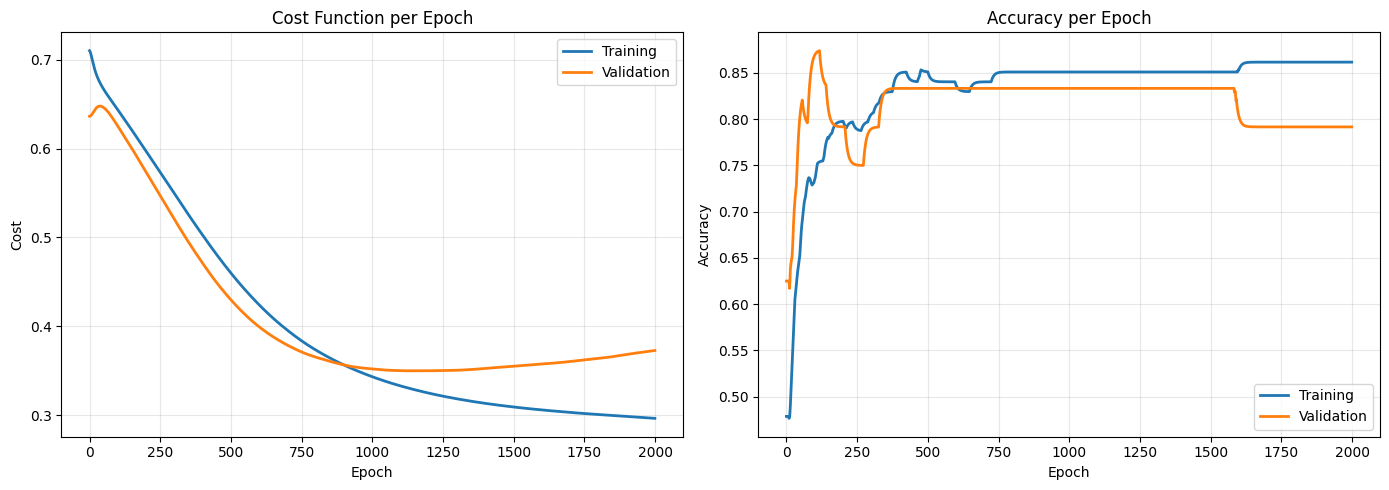

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

cost_train_smooth = smooth_curve(cost_train, 0.9)
cost_val_smooth = smooth_curve(cost_val, 0.9)
acc_train_smooth = smooth_curve(acc_train, 0.9)
acc_val_smooth = smooth_curve(acc_val, 0.9)

ax1.plot(cost_train_smooth, label='Training', linewidth=2)
ax1.plot(cost_val_smooth, label='Validation', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cost')
ax1.set_title('Cost Function per Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(acc_train_smooth, label='Training', linewidth=2)
ax2.plot(acc_val_smooth, label='Validation', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy per Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Decision boundary

- Plots the estimated probability over a grid and draws the decision boundary (probability = 0.5).
- **Note:** The axes correspond to normalized features (Z-score).


/tmp/ipython-input-2421402192.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[pos, 0], X[pos, 1], c='red', marker='+', s=150,


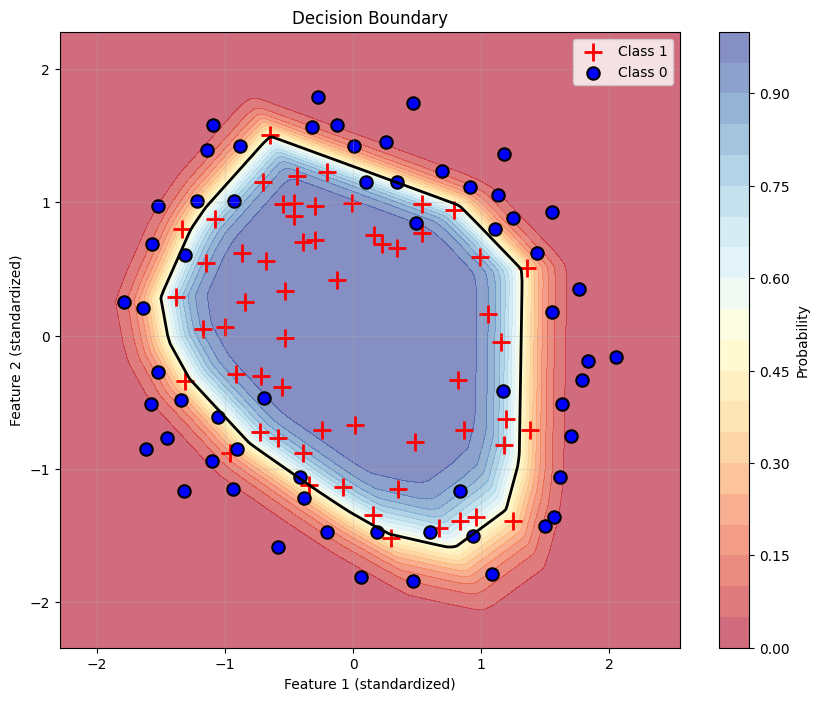

In [15]:
# FUNCTION TO PLOT THE DECISION BOUNDARY
def plot_decision_boundary(net, X, y):
    # grid limits (with margin)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    h_step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_step),
                         np.arange(y_min, y_max, h_step))

    # compute probability for each grid point
    Z = np.array([h(np.array([x1, x2]), net)
                  for x1, x2 in zip(xx.ravel(), yy.ravel())])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, levels=20, alpha=0.6, cmap='RdYlBu')
    plt.colorbar(label='Probability')
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)  # decision boundary (prob = 0.5)

    pos = (y == 1)
    neg = (y == 0)
    plt.scatter(X[pos, 0], X[pos, 1], c='red', marker='+', s=150,
                label='Class 1', edgecolors='black', linewidths=2)
    plt.scatter(X[neg, 0], X[neg, 1], c='blue', marker='o', s=80,
                label='Class 0', edgecolors='black', linewidths=1.5)

    plt.xlabel('Feature 1 (standardized)')
    plt.ylabel('Feature 2 (standardized)')
    plt.title('Decision Boundary')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot the decision boundary using normalized X and y
plot_decision_boundary(net, X, y)



--- TRAINING ---
Confusion Matrix:
[[39  6]
 [ 7 42]]
Accuracy: 0.8617 | Precision: 0.8750 | Recall: 0.8571 | F1-Score: 0.8660

--- VALIDATION ---
Confusion Matrix:
[[12  3]
 [ 2  7]]
Accuracy: 0.7917 | Precision: 0.7000 | Recall: 0.7778 | F1-Score: 0.7368


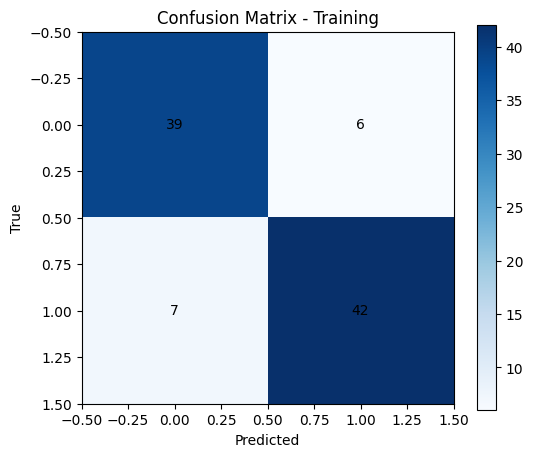

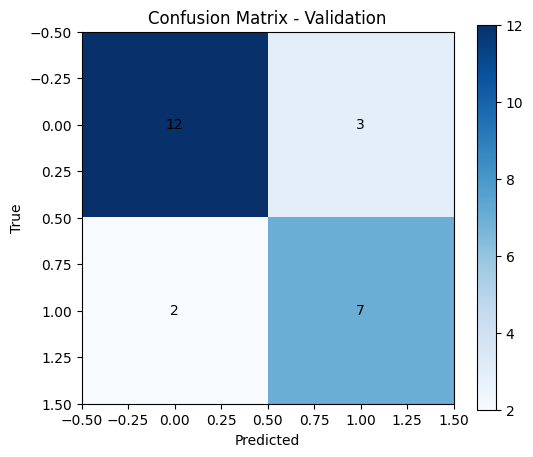

In [16]:
def compute_metrics(y_true, y_pred):
    # 2x2 Confusion Matrix
    cm = np.zeros((2, 2), dtype=int)
    for real, pred in zip(y_true, y_pred):
        cm[real, pred] += 1

    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    accuracy_val = (TP + TN) / np.sum(cm)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return cm, accuracy_val, precision, recall, f1


# Training predictions
y_train_pred = np.array([classify(h(x, net)) for x in X_train])
cm_train, acc_train, prec_train, rec_train, f1_train = compute_metrics(y_train, y_train_pred)

# Validation predictions
y_val_pred = np.array([classify(h(x, net)) for x in X_val])
cm_val, acc_val_final, prec_val, rec_val, f1_val = compute_metrics(y_val, y_val_pred)

# Display results
print("\n--- TRAINING ---")
print("Confusion Matrix:")
print(cm_train)
print(f"Accuracy: {acc_train:.4f} | Precision: {prec_train:.4f} | Recall: {rec_train:.4f} | F1-Score: {f1_train:.4f}")

print("\n--- VALIDATION ---")
print("Confusion Matrix:")
print(cm_val)
print(f"Accuracy: {acc_val_final:.4f} | Precision: {prec_val:.4f} | Recall: {rec_val:.4f} | F1-Score: {f1_val:.4f}")


# Function to plot the confusion matrix
def plot_cm(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.show()


# Plot confusion matrices
plot_cm(cm_train, "Confusion Matrix - Training")
plot_cm(cm_val, "Confusion Matrix - Validation")


# Gradient Computation Validation


In [17]:
# NUMERICAL GRADIENT VALIDATION – CODE 1
def numerical_gradient_check(net, X, y, epsilon=1e-7, num_checks=10):
    """
    Validates the gradient computed by backpropagation using
    numerical approximation (finite differences).
    """
    print("\n" + "=" * 60)
    print("NUMERICAL GRADIENT VALIDATION (NO REGULARIZATION)")
    print("=" * 60)

    # Analytical gradient via backprop
    # grad_analytical = backprop(net, X, y)  --> this would compute it over the full dataset

    # Select a few random samples for testing
    np.random.seed(42)
    indices = np.random.choice(len(X), min(num_checks, len(X)), replace=False)

    relative_errors = []

    for idx in indices:
        x_sample = X[idx]
        y_sample = y[idx]

        # Compute analytical gradient for a single sample
        grad_analytical = backprop(
            net,
            x_sample.reshape(1, -1),
            np.array([y_sample])
        )

        # Check gradients for each parameter in the network
        for layer_idx in range(len(net)):
            for param in ['w', 'b']:
                param_shape = net[layer_idx][param].shape

                # Randomly select one parameter entry to check
                if param == 'w':
                    i, j = (
                        np.random.randint(0, param_shape[0]),
                        np.random.randint(0, param_shape[1])
                    )
                else:  # 'b'
                    i, j = np.random.randint(0, param_shape[0]), 0

                # Save original value
                original_value = net[layer_idx][param][i, j].copy()

                # Compute J(theta + epsilon)
                net[layer_idx][param][i, j] = original_value + epsilon
                J_plus = cost(h(x_sample, net), y_sample)

                # Compute J(theta - epsilon)
                net[layer_idx][param][i, j] = original_value - epsilon
                J_minus = cost(h(x_sample, net), y_sample)

                # Numerical gradient
                grad_numerical = (J_plus - J_minus) / (2 * epsilon)

                # Analytical gradient
                grad_analytical_val = grad_analytical[layer_idx][param][i, j]

                # Restore original value
                net[layer_idx][param][i, j] = original_value

                # Relative error
                if abs(grad_numerical) > 1e-10 or abs(grad_analytical_val) > 1e-10:
                    relative_error = abs(grad_numerical - grad_analytical_val) / max(
                        abs(grad_numerical),
                        abs(grad_analytical_val)
                    )
                else:
                    relative_error = 0.0

                relative_errors.append(relative_error)

                print(
                    f"Layer {layer_idx}, {param}[{i},{j}]: "
                    f"Analytical = {grad_analytical_val:10.6f}, "
                    f"Numerical = {grad_numerical:10.6f}, "
                    f"Rel. Error = {relative_error:8.2e}"
                )

    # Statistics
    relative_errors = np.array(relative_errors)
    print("\nVALIDATION STATISTICS:")
    print(f"Mean relative error: {np.mean(relative_errors):.2e}")
    print(f"Max relative error:  {np.max(relative_errors):.2e}")
    print(f"Min relative error:  {np.min(relative_errors):.2e}")
    print(f"Checks performed:   {len(relative_errors)}")

    # Success criteria
    if np.mean(relative_errors) < 1e-7:
        print("VALIDATION PASSED: Gradients are consistent!")
    elif np.mean(relative_errors) < 1e-5:
        print("ACCEPTABLE VALIDATION: Small gradient differences detected.")
    else:
        print("VALIDATION FAILED: Large gradient discrepancies detected!")

    return relative_errors


# Run gradient validation
print("Running numerical gradient validation...")
errors = numerical_gradient_check(
    net,
    X_train[:100],
    y_train[:100]  # use a subset for speed
)


Running numerical gradient validation...

NUMERICAL GRADIENT VALIDATION (NO REGULARIZATION)
Layer 0, w[87,0]: Analytical =  -0.010233, Numerical =  -0.010233, Rel. Error = 1.80e-08
Layer 0, b[7,0]: Analytical =   0.000000, Numerical =   0.000000, Rel. Error = 0.00e+00
Layer 1, w[0,87]: Analytical =  -0.001056, Numerical =  -0.001056, Rel. Error = 8.76e-07
Layer 1, b[0,0]: Analytical =  -0.019861, Numerical =  -0.019861, Rel. Error = 1.12e-08
Layer 0, w[62,0]: Analytical =  -0.011084, Numerical =  -0.011084, Rel. Error = 7.04e-08
Layer 0, b[80,0]: Analytical =   0.000000, Numerical =   0.000000, Rel. Error = 0.00e+00
Layer 1, w[0,7]: Analytical =  -0.087607, Numerical =  -0.087607, Rel. Error = 9.33e-09
Layer 1, b[0,0]: Analytical =  -0.233894, Numerical =  -0.233894, Rel. Error = 1.21e-09
Layer 0, w[34,0]: Analytical =   0.000000, Numerical =   0.000000, Rel. Error = 0.00e+00
Layer 0, b[32,0]: Analytical =   0.000000, Numerical =   0.000000, Rel. Error = 0.00e+00
Layer 1, w[0,4]: Analy